!pip install git+https://gitlab.com/pavanello-research-group/qmlearn.git

!pip install matplotlib

!wget https://gitlab.com/pavanello-research-group/qmlearn/-/raw/main/examples/examples/h2o/h2o_md_300_QML_set.hdf5

## Creating a QMModel: Fitting the model

In [1]:
from qmlearn.drivers.mol import QMMol
from qmlearn.io.hdf5 import DBHDF5
from qmlearn.model import QMModel

##### Open a Database

1) Import a database to get the reference molecule `refqmmol`, the traning atoms `train_atoms`, and the traning properties `properties`.

In [2]:
dbfile = 'h2o_vib_QML_set.hdf5'
db = DBHDF5(dbfile)
db.names

['rks', 'rks/qmmol', 'rks/train_atoms_36', 'rks/train_props_36']

In [3]:
db.get_names('*/train*')

['rks/train_atoms_36', 'rks/train_props_36']

In [4]:
refqmmol = db.read_qmmol(db.get_names('*/qmmol')[0])
train_atoms = db.read_images(db.get_names('*/train_atoms*')[0])
properties = db.read_properties(db.get_names('*/train_prop*')[0])
db.close()

#####  Feature-Target definition

2) Define the feature, covariates or predictors by `X` , and the label, target or response `y`.

In [5]:
X = properties['vext']
y = properties['gamma'] 

##### Call scikit-learn model

3) Define the scikit-learn model to fit `X` and `y`, in a a dictionary called `mmodels`.

In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
mmodels={
    'gamma': KernelRidge(alpha=0.1,kernel='linear'),
    'd_gamma': LinearRegression(),
    'd_energy': LinearRegression(),
    'd_forces': LinearRegression(),
}

##### Fitting

4) Creat the object `model` and fit it.

In [7]:
model = QMModel(mmodels=mmodels, refqmmol = refqmmol)

In [8]:
model.fit(X,y);

## Creating a QMModel: Predicting with the model

##### Predicting gamma

1) Use `model.refqmmol.duplicate` object to initialize a specific geometry, as well as, define the shape of the external potential `vext`, to be use in `gamma.reshape`.

In [9]:
itest = 5

In [10]:
qmmol=model.refqmmol.duplicate(train_atoms[itest])

In [11]:
shape = qmmol.vext.shape

2) Predict gamma using `model.predict` function.

3) Use `qmmol.calc_etotal` to use PySCF engine and predict the total energy based on the predicted `gamma`. 

4) Get the energy difference against the exact gamma using PySCF engine.

In [12]:
gamma = model.predict(qmmol)
gamma = gamma.reshape(shape)
qmmol.calc_etotal(gamma)-properties['energy'][itest]

-0.000498411246582009

##### Delta learning proccess

6) Predicted all the 1-RDM or gamma in train_atoms. 

In [13]:
gammas = []
for i, mol in enumerate(train_atoms):
    dm = model.predict(mol, refatoms=mol).reshape(shape)
    gammas.append(dm)

7) Do the delta learning proccess among `gammas` and  the 'true' `gamma`, `energy` and `forces`.

In [14]:
model.fit(gammas, properties['gamma'], method = 'd_gamma')
model.fit(gammas, properties['energy'], method = 'd_energy')
model.fit(gammas, properties['forces'], method = 'd_forces');

8) Check the energy difference against the exact gamma using PySCF engine.

In [15]:
qmmol.calc_etotal(gamma)-properties['energy'][itest]

-0.000498411246582009

In [16]:
gamma_d = model.predict(gamma, method='d_gamma').reshape(shape)
qmmol.calc_etotal(gamma_d)-properties['energy'][itest]

6.639462753810221e-06

In [17]:
model.predict(gamma, method='d_energy')-properties['energy'][itest]

-1.1608712213728722e-07

9) Plot the exact gamma $\gamma_{exact}$, and its difference between the gamma from a first learning proccess $\gamma-\gamma_{exact}$, and the delta learning gamma $(\gamma+\Delta\gamma)-\gamma_{exact}$ . 

In [18]:
gamma2 = model.predict(gamma, method='d_gamma').reshape(shape)

In [19]:
gamma_exact= properties['gamma'][itest]

In [20]:
import matplotlib.pyplot as plt

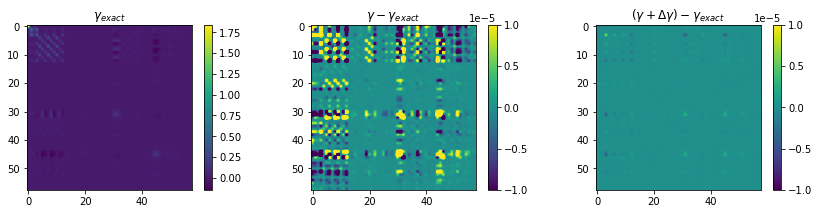

In [21]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].imshow(gamma_exact)
im1 = axs[1].imshow(gamma-gamma_exact, vmin=-1E-5, vmax=1E-5)
im2 = axs[2].imshow(gamma2-gamma_exact, vmin=-1E-5, vmax=1E-5)
axs[0].set_title(r'$\gamma_{exact}$')
axs[1].set_title(r'$\gamma-\gamma_{exact}$')
axs[2].set_title(r'$(\gamma+\Delta\gamma)-\gamma_{exact}$')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])
fig.tight_layout()